In [ ]:
!pip install rdd

  Preparing metadata (setup.py) ... done
  Created wheel for rdd: filename=rdd-0.0.3-py3-none-any.whl size=4701 sha256=2278a727b61bc668bbf76d07f1f06bd6664fc4400a79d005dc7aa4bbecf07ae4
  Stored in directory: /root/.cache/pip/wheels/57/8e/5d/071083a8b0c6df288f3faa49f46ee0d312a4d058628f1c5289
Successfully built rdd


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from rdd import rdd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf

In [ ]:
data= pd.read_stata('lee-data.dta')

<Axes: xlabel='dem_margin', ylabel='treatment'>

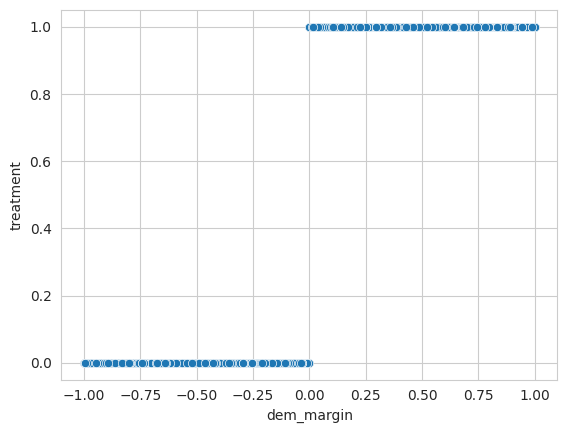

In [ ]:
def calculate_dem_margin(row):
    if row['origvote'] == row['highestvote']:
        return (row['origvote'] - row['sechighestvote']) / row['totvote']
    else:
        return (row['origvote'] - row['highestvote']) / row['totvote']

def calculate_treatment(row):
    if row['origvote'] == row['highestvote']:
        return 1
    else:
        return 0

data['dem_margin'] = data.apply(calculate_dem_margin, axis=1)
data['treatment'] = data.apply(calculate_treatment, axis=1)

sns.scatterplot(data = data, x='dem_margin', y='treatment')

In [ ]:
data = data[data['dem_margin'] <= 0.25]
data = data[data['dem_margin'] >= -0.25]

In [ ]:
data['vote_share'] = data.apply(lambda row: row['origvote'] / row['totvote'], axis=1)
data = data.sort_values(by='yearel')
data['dem_vote_share_1'] = data.groupby(['state', 'distnum', 'distid', 'party'])['vote_share'].shift(-1)
data['dem_vote_share_1d'] = data[data['party'] == 100]['dem_vote_share_1']
data['dem_vote_share_2'] = data.groupby(['state', 'distnum', 'distid', 'party'])['vote_share'].shift(1)
data['dem_vote_share_2d'] = data[data['party'] == 100]['dem_vote_share_2']


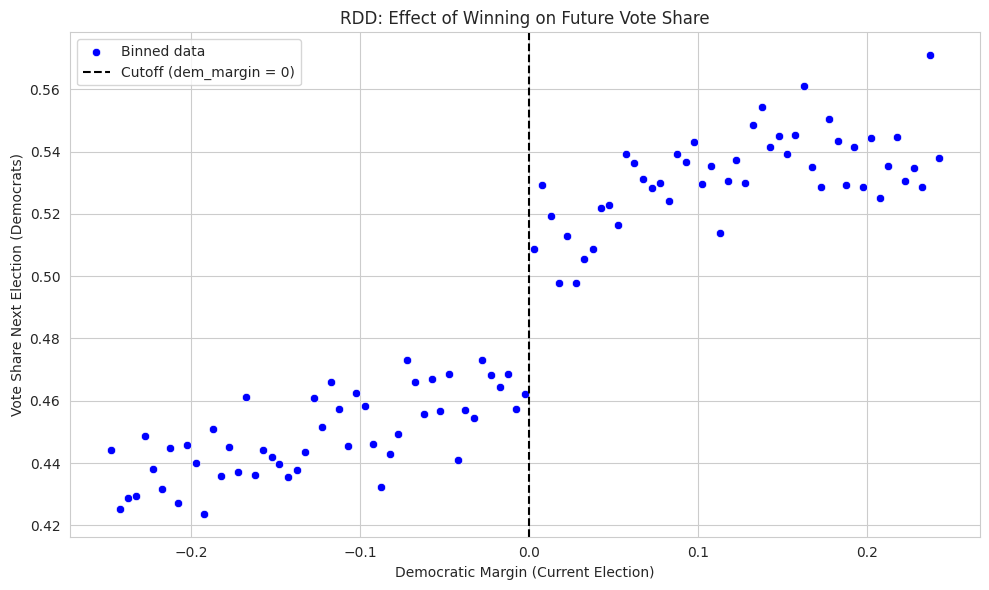

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Настройка стиля
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Функция для биннинга данных
bin_width = 0.005
bins = np.arange(data['dem_margin'].min(), data['dem_margin'].max(), bin_width)
data['bin'] = pd.cut(data['dem_margin'], bins=bins)

# Усреднение по бинам
binned_data = data.groupby('bin', observed=True).agg(
    x_mean=('dem_margin', 'mean'),
    y_mean=('dem_vote_share_1d', 'mean'),
    count=('dem_vote_share_1d', 'count')
).reset_index()

# Отсеиваем бины с малым количеством наблюдений
binned_data = binned_data[binned_data['count'] > 5]

# Разделяем данные на левую и правую часть от точки разрыва
cutoff = 0
left_mask = binned_data['x_mean'] < cutoff
right_mask = binned_data['x_mean'] >= cutoff

# Обучаем модели регрессии
model_left = LinearRegression().fit(
    binned_data[left_mask]['x_mean'].values.reshape(-1,1),
    binned_data[left_mask]['y_mean']
)
model_right = LinearRegression().fit(
    binned_data[right_mask]['x_mean'].values.reshape(-1,1),
    binned_data[right_mask]['y_mean']
)

# Генерируем предсказания
x_left = np.linspace(binned_data['x_mean'].min(), cutoff, 100)
y_left = model_left.predict(x_left.reshape(-1,1))

x_right = np.linspace(cutoff, binned_data['x_mean'].max(), 100)
y_right = model_right.predict(x_right.reshape(-1,1))

# Рисуем график
sns.scatterplot(
    data=binned_data,
    x='x_mean',
    y='y_mean',
    color='blue',
    label='Binned data'
)

plt.axvline(
    x=0,
    color='black',
    linestyle='--',
    label='Cutoff (dem_margin = 0)'
)


# Подписи и легенда
plt.xlabel('Democratic Margin (Current Election)')
plt.ylabel('Vote Share Next Election (Democrats)')
plt.title('RDD: Effect of Winning on Future Vote Share')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model = rdd.rdd(data, 'dem_margin', 'dem_vote_share_1d', cut=0)
print(model.fit().summary())

Estimation Equation:	 dem_vote_share_1d ~ TREATED + dem_margin
                            WLS Regression Results                            
Dep. Variable:      dem_vote_share_1d   R-squared:                       0.320
Model:                            WLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     901.2
Date:                Wed, 26 Mar 2025   Prob (F-statistic):          1.96e-321
Time:                        19:54:03   Log-Likelihood:                 5265.3
No. Observations:                3830   AIC:                        -1.052e+04
Df Residuals:                    3827   BIC:                        -1.051e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

In [ ]:
rdd_df = data.assign(threshold=(data['dem_margin'] > 0).astype(int))
model = smf.wls("dem_vote_share_1d~dem_margin*threshold", rdd_df).fit()

print(model.summary())

                            WLS Regression Results                            
Dep. Variable:      dem_vote_share_1d   R-squared:                       0.320
Model:                            WLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     600.8
Date:                Wed, 26 Mar 2025   Prob (F-statistic):          5.75e-320
Time:                        19:42:15   Log-Likelihood:                 5265.4
No. Observations:                3830   AIC:                        -1.052e+04
Df Residuals:                    3826   BIC:                        -1.050e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.4654 

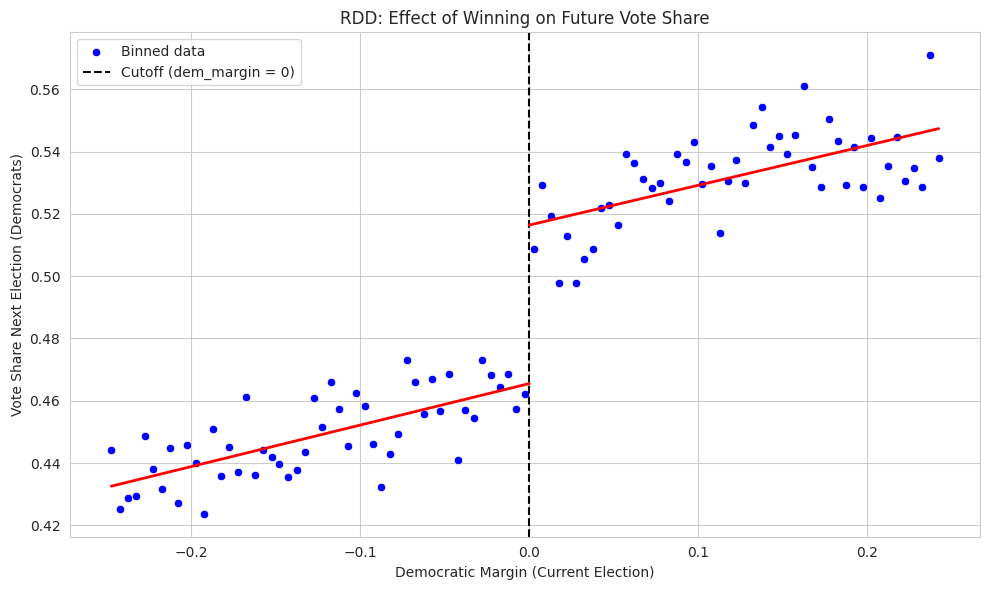

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Настройка стиля
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Функция для биннинга данных
bin_width = 0.005
bins = np.arange(data['dem_margin'].min(), data['dem_margin'].max(), bin_width)
data['bin'] = pd.cut(data['dem_margin'], bins=bins)

# Усреднение по бинам
binned_data = data.groupby('bin', observed=True).agg(
    x_mean=('dem_margin', 'mean'),
    y_mean=('dem_vote_share_1d', 'mean'),
    count=('dem_vote_share_1d', 'count')
).reset_index()

# Отсеиваем бины с малым количеством наблюдений
binned_data = binned_data[binned_data['count'] > 5]

# Разделяем данные на левую и правую часть от точки разрыва
cutoff = 0
left_mask = binned_data['x_mean'] < cutoff
right_mask = binned_data['x_mean'] >= cutoff

# Обучаем модели регрессии
model_left = LinearRegression().fit(
    binned_data[left_mask]['x_mean'].values.reshape(-1,1),
    binned_data[left_mask]['y_mean']
)
model_right = LinearRegression().fit(
    binned_data[right_mask]['x_mean'].values.reshape(-1,1),
    binned_data[right_mask]['y_mean']
)

# Генерируем предсказания
x_left = np.linspace(binned_data['x_mean'].min(), cutoff, 100)
y_left = model_left.predict(x_left.reshape(-1,1))

x_right = np.linspace(cutoff, binned_data['x_mean'].max(), 100)
y_right = model_right.predict(x_right.reshape(-1,1))

# Рисуем график
sns.scatterplot(
    data=binned_data,
    x='x_mean',
    y='y_mean',
    color='blue',
    label='Binned data'
)

plt.axvline(
    x=0,
    color='black',
    linestyle='--',
    label='Cutoff (dem_margin = 0)'
)

plt.plot(
    x_left,
    y_left,
    color='red',
    linewidth=2,

)

plt.plot(
    x_right,
    y_right,
    color='red',
    linewidth=2,

)

# Подписи и легенда
plt.xlabel('Democratic Margin (Current Election)')
plt.ylabel('Vote Share Next Election (Democrats)')
plt.title('RDD: Effect of Winning on Future Vote Share')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
rdd_df = data.assign(threshold=(data['dem_margin'] > 0).astype(int))
model = smf.wls("dem_vote_share_2d~dem_margin*threshold", rdd_df).fit()

print(model.summary())



                            WLS Regression Results                            
Dep. Variable:      dem_vote_share_2d   R-squared:                       0.293
Model:                            WLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     528.0
Date:                Wed, 26 Mar 2025   Prob (F-statistic):          3.95e-287
Time:                        19:31:41   Log-Likelihood:                 5232.8
No. Observations:                3830   AIC:                        -1.046e+04
Df Residuals:                    3826   BIC:                        -1.043e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.4831 

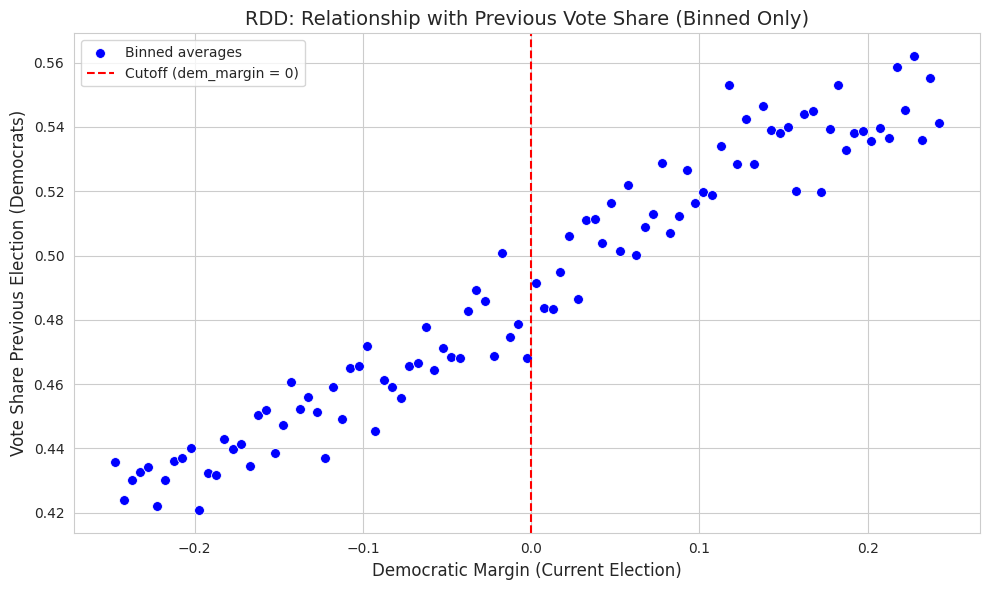

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка стиля
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Биннинг данных
bin_width = 0.005
bins = np.arange(data['dem_margin'].min(), data['dem_margin'].max(), bin_width)
data['bin'] = pd.cut(data['dem_margin'], bins=bins)

# Усреднение по бинам
binned_data = data.groupby('bin', observed=True).agg(
    x_mean=('dem_margin', 'mean'),
    y_mean=('dem_vote_share_2d', 'mean'),
    count=('dem_vote_share_2d', 'count')
).reset_index()

# Фильтрация бинов
binned_data = binned_data[binned_data['count'] > 5]

# Построение графика
sns.scatterplot(
    data=binned_data,
    x='x_mean',
    y='y_mean',
    color='blue',
    s=50,
    label='Binned averages'
)

plt.axvline(
    x=0,
    color='red',
    linestyle='--',
    linewidth=1.5,
    label='Cutoff (dem_margin = 0)'
)

plt.xlabel('Democratic Margin (Current Election)', fontsize=12)
plt.ylabel('Vote Share Previous Election (Democrats)', fontsize=12)
plt.title('RDD: Relationship with Previous Vote Share (Binned Only)', fontsize=14)
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
rdd_df = data.assign(threshold=(data['dem_margin'] > 0).astype(int))
model = smf.wls("officeexp~dem_margin*threshold", rdd_df).fit()

print(model.summary())


                            WLS Regression Results                            
Dep. Variable:              officeexp   R-squared:                       0.183
Model:                            WLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     650.1
Date:                Wed, 26 Mar 2025   Prob (F-statistic):               0.00
Time:                        19:32:58   Log-Likelihood:                -19963.
No. Observations:                8738   AIC:                         3.993e+04
Df Residuals:                    8734   BIC:                         3.996e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.9929 

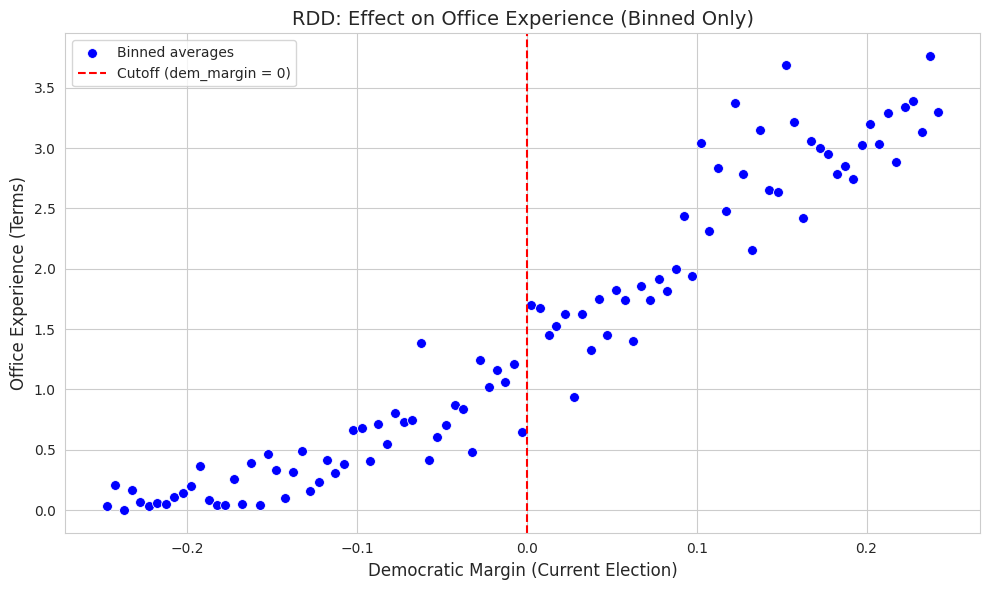

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка стиля
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Биннинг данных
bin_width = 0.005
bins = np.arange(data['dem_margin'].min(), data['dem_margin'].max(), bin_width)
data['bin'] = pd.cut(data['dem_margin'], bins=bins)

# Усреднение по бинам
binned_data = data.groupby('bin', observed=True).agg(
    x_mean=('dem_margin', 'mean'),
    y_mean=('officeexp', 'mean'),
    count=('officeexp', 'count')
).reset_index()

# Фильтрация бинов
binned_data = binned_data[binned_data['count'] > 5]

# Построение графика
sns.scatterplot(
    data=binned_data,
    x='x_mean',
    y='y_mean',
    color='blue',
    s=50,
    label='Binned averages'
)

plt.axvline(
    x=0,
    color='red',
    linestyle='--',
    linewidth=1.5,
    label='Cutoff (dem_margin = 0)'
)

plt.xlabel('Democratic Margin (Current Election)', fontsize=12)
plt.ylabel('Office Experience (Terms)', fontsize=12)
plt.title('RDD: Effect on Office Experience (Binned Only)', fontsize=14)
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()